In [1]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy import stats
from scipy.signal import periodogram, welch

In [2]:
columns_labels = [ 'Device ID', 'accelerometer x', 'accelerometer y', 'accelerometer z',
    'gyroscope x', 'gyroscope y', 'gyroscope z', 'magnetometer x', 'magnetometer y', 'magnetometer z',
    'Timestamp', 'Activity Label']

activities = np.array(['Stand', 'Sit', 'Sit and Talk', 'Walk', 'Walk and Talk', 'Climb Stair (up/down)',
    'Climb Stair (up/down) and talk', 'Stand -> Sit', 'Sit -> Stand', 'Stand -> Sit and talk', 'Sit -> Stand and talk',
    'Stand -> walk', 'Walk -> stand', 'Stand -> climb stairs (up/down)(and talk)', 'Climb stairs (up/down) -> walk',
    'Climb stairs (up/down) and talk -> walk and talk'])

sensors = ['Acc', 'Gyr', 'Mag']

k_value = [3, 3.5, 4]

### 2. Read Files
Read files 

-> Dispositivo do pulso direito (Dev2) 

-> Leitura do pulso direito de todos os utilizadores

In [3]:
def readFiles(devi):
    dev = [0]*15
    for id in range(15):
        file = "part" + str(id)
        pasta = "dataset\part" + str(id)

        f = file + "dev" + str(devi) + ".csv"
        dir = os.path.join(pasta, f)
        dev[id] = np.genfromtxt(dir, delimiter=',')

    dFrame = pd.DataFrame(np.concatenate(dev), columns=columns_labels)
    labels = activities[dFrame['Activity Label'].astype(int)-1]
    dFrame['Label Name'] = labels
    display(dFrame)

    return [np.concatenate(dev), dFrame]

[data, dataFrame] = readFiles(2)

,Device ID,accelerometer x,accelerometer y,accelerometer z,gyroscope x,gyroscope y,gyroscope z,magnetometer x,magnetometer y,magnetometer z,Timestamp,Activity Label,Label Name
0,2.0,3.0317,9.0450,3.1739,0.76247,3.7071,-0.31384,0.57764,0.68849,1.2654,63.629,1.0,Stand
1,2.0,2.9591,9.0436,3.1400,0.40588,4.6682,-0.10148,0.58385,0.68849,1.2741,83.160,1.0,Stand
2,2.0,2.9465,9.0545,3.0799,0.24230,5.5225,0.34857,0.56522,0.67857,1.2675,102.690,1.0,Stand
3,2.0,2.7898,9.0528,3.0726,0.49858,6.3463,0.61127,0.56108,0.65476,1.2610,122.220,1.0,Stand
4,2.0,2.6924,9.0377,2.9794,0.63197,6.6972,1.00560,0.57764,0.69246,1.2675,141.750,1.0,Stand
...,...,...,...,...,...,...,...,...,...,...,...,...,...
781817,2.0,1.6802,9.5395,2.9636,0.83324,1.9832,0.87140,-0.38716,0.87103,1.3289,1042000.000,1.0,Stand
781818,2.0,1.7042,9.5639,2.9504,1.03060,1.8002,0.54192,-0.37474,0.86508,1.3399,1042000.000,1.0,Stand
781819,2.0,1.7283,9.5641,2.9496,1.05330,1.3577,0.89447,-0.35818,0.92857,1.3531,1042000.000,1.0,Stand
781820,2.0,1.7285,9.5646,2.9737,1.03550,1.4340,0.78856,-0.36232,0.90675,1.3377,1042000.000,1.0,Stand


### 3. Módulo

-> Módulo do aceleração, giroscópio, magnenómetro

-> Cálculo feito por linha da tabela

In [4]:
def modulo(dFrame):

    for i in range(16):
        acc = np.sqrt(dFrame['accelerometer x']**2 + dFrame['accelerometer y']**2 + dFrame['accelerometer z']**2)
        gir = np.sqrt(dFrame['gyroscope x']**2 + dFrame['gyroscope y']**2 + dFrame['gyroscope z']**2)
        mag = np.sqrt(dFrame['magnetometer x']**2 + dFrame['magnetometer y']**2 + dFrame['magnetometer z']**2)

    data = pd.DataFrame({'ID': dFrame['Device ID'], 'Acc': acc, 'Gyr': gir, 'Mag': mag, 
                            'Label ID': dFrame['Activity Label'].astype(int), 'Label Name': dFrame['Label Name']})

    #display(data)

    return data

mod_data = modulo(dataFrame)

### 3.1. Boxplot dos módulos

-> Boxplot de cada módulo agrupado por atividade (Label ID)

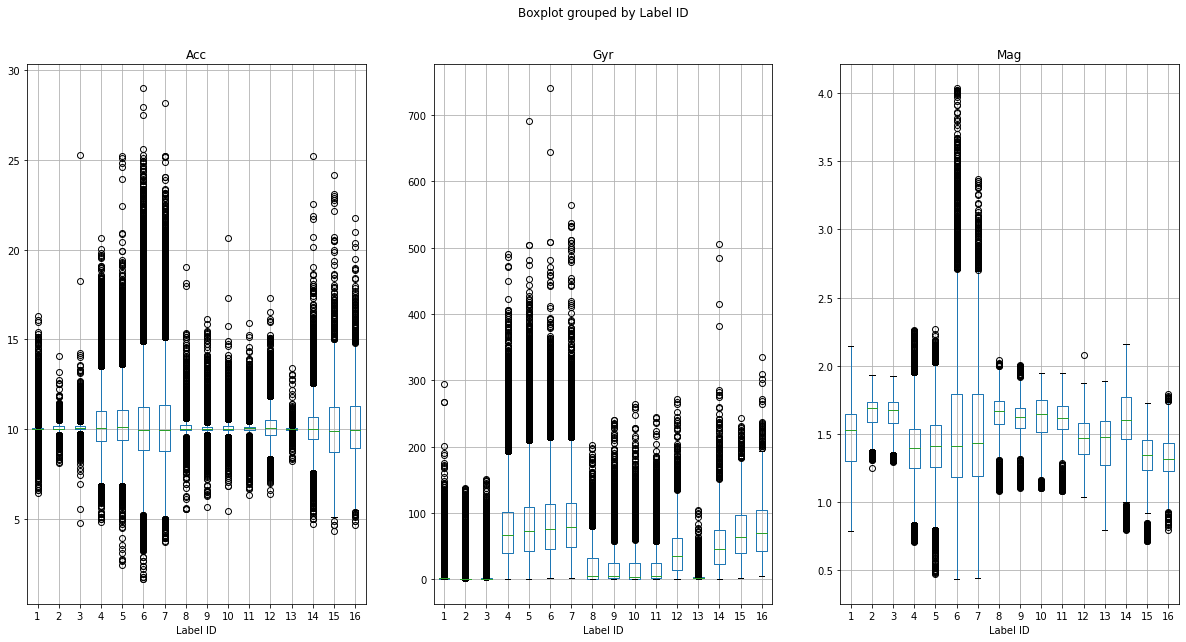

In [5]:
def boxplot(mod_data):
    fig, axes = plt.subplots(1,3, figsize=(20,10))

    mod_data.boxplot(by ='Label ID', column = ['Acc'], ax=axes.flatten()[0])
    mod_data.boxplot(by ='Label ID', column = ['Gyr'], ax=axes.flatten()[1])
    mod_data.boxplot(by ='Label ID', column = ['Mag'], ax=axes.flatten()[2])

boxplot(mod_data)

### 3.2. Densidade

[Q1 − k × IQR,Q3 + k × IQR] -> Not outlier

d = (n0 / nr) * 100

In [12]:
def outliers(data_act, sensor):
    k = 1.5
    quantil = data_act[sensor].quantile([0.25,0.75])
    iqr = quantil[0.75] - quantil[0.25]
    limite = [quantil[0.25] - k*iqr, quantil[0.75] + k*iqr]

    out = data_act.loc[(data_act[sensor] < limite[0]) | (data_act[sensor] > limite[1])] 
    not_out = data_act.loc[(data_act[sensor] >= limite[0]) & (data_act[sensor] <= limite[1])]

    return [out, not_out]


def density(mod_data):
    den = [pd.DataFrame(np.arange(1,17)), pd.DataFrame(activities)]
    den[0].columns = ['Label']
    den[1].columns = ['Label Name']

    for s in sensors:
        aux = [[],[],[]]
        for id in range(1,17):
            activity = mod_data.loc[mod_data["Label ID"] == id]
            n_total = activity.shape[0]
            [out, not_out] = outliers(activity, s)

            d = (out.shape[0]/n_total)*100

            aux[0].append(n_total) # Número de total de pontos
            aux[1].append(out.shape[0]) # Número de outliers
            aux[2].append(d) # Densidade

        aux[0] = pd.DataFrame(aux[0])
        aux[0].columns = [s + ' N_Total']
        aux[1] = pd.DataFrame(aux[1])
        aux[1].columns = [s + ' N_Outliers']
        aux[2] = pd.DataFrame(aux[2])
        aux[2].columns= [s + ' Density']

        aux = pd.concat(aux, axis=1)

        den.append(aux)


    den = pd.concat(den, axis=1)
    den.index = np.arange(1,17)
    
    return den
        

den = density(mod_data)
display(den)


,Label,Label Name,Acc N_Total,Acc N_Outliers,Acc Density,Gyr N_Total,Gyr N_Outliers,Gyr Density,Mag N_Total,Mag N_Outliers,Mag Density
1,1,Stand,157882,6624,4.195538,157882,14975,9.484932,157882,0,0.000000
2,2,Sit,83968,181,0.215558,83968,5581,6.646580,83968,5603,6.672780
3,3,Sit and Talk,81152,417,0.513851,81152,7399,9.117459,81152,3868,4.766364
4,4,Walk,139934,4941,3.530950,139934,2268,1.620764,139934,2030,1.450684
5,5,Walk and Talk,142366,4951,3.477656,142366,2033,1.428009,142366,1906,1.338803
6,6,Climb Stair (up/down),89359,4616,5.165680,89359,1339,1.498450,89359,349,0.390559
7,7,Climb Stair (up/down) and talk,43791,1977,4.514626,43791,908,2.073485,43791,97,0.221507
8,8,Stand -> Sit,6656,1028,15.444712,6656,497,7.466947,6656,232,3.485577
9,9,Sit -> Stand,5632,1115,19.797585,5632,607,10.777699,5632,414,7.350852
10,10,Stand -> Sit and talk,6656,1020,15.324519,6656,688,10.336538,6656,56,0.841346


### 3.4. Z-Score

z = (X - media) / std

|z| < k -> z <= k & z >= -k

,Label,Label Name,Acc N_Total,Acc N_Outliers,3.0,3.5,4.0
1,1,Stand,157882,6624,1328,1123,977
2,2,Sit,83968,181,199,173,155
3,3,Sit and Talk,81152,417,295,245,216
4,4,Walk,139934,4941,1497,681,283
5,5,Walk and Talk,142366,4951,1522,720,302
6,6,Climb Stair (up/down),89359,4616,1163,573,288
7,7,Climb Stair (up/down) and talk,43791,1977,595,292,152
8,8,Stand -> Sit,6656,1028,122,91,76
9,9,Sit -> Stand,5632,1115,143,106,77
10,10,Stand -> Sit and talk,6656,1020,148,99,68


,Label,Label Name,Gyr N_Total,Gyr N_Outliers,3.0,3.5,4.0
1,1,Stand,157882,14975,2348,2003,1744
2,2,Sit,83968,5581,392,356,323
3,3,Sit and Talk,81152,7399,518,459,413
4,4,Walk,139934,2268,1274,700,421
5,5,Walk and Talk,142366,2033,1235,691,395
6,6,Climb Stair (up/down),89359,1339,810,426,201
7,7,Climb Stair (up/down) and talk,43791,908,480,266,161
8,8,Stand -> Sit,6656,497,122,56,27
9,9,Sit -> Stand,5632,607,123,84,60
10,10,Stand -> Sit and talk,6656,688,141,81,50


,Label,Label Name,Mag N_Total,Mag N_Outliers,3.0,3.5,4.0
1,1,Stand,157882,0,0,0,0
2,2,Sit,83968,5603,1,1,0
3,3,Sit and Talk,81152,3868,0,0,0
4,4,Walk,139934,2030,116,41,3
5,5,Walk and Talk,142366,1906,92,28,0
6,6,Climb Stair (up/down),89359,349,441,322,200
7,7,Climb Stair (up/down) and talk,43791,97,160,89,42
8,8,Stand -> Sit,6656,232,168,16,0
9,9,Sit -> Stand,5632,414,10,0,0
10,10,Stand -> Sit and talk,6656,56,25,0,0


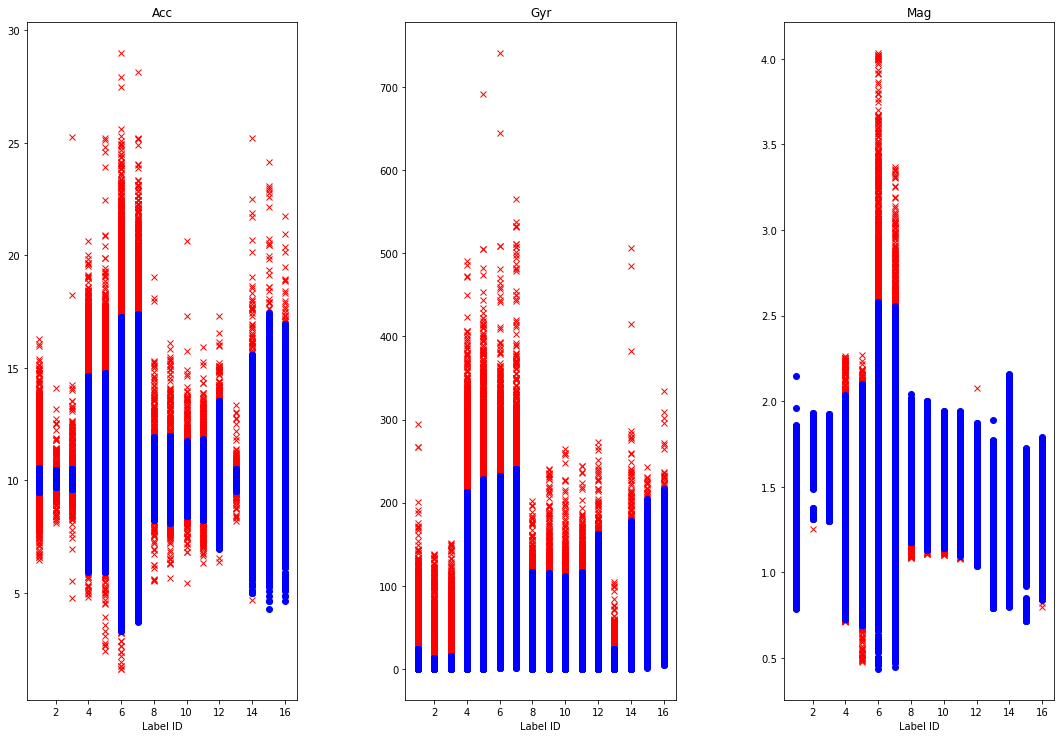

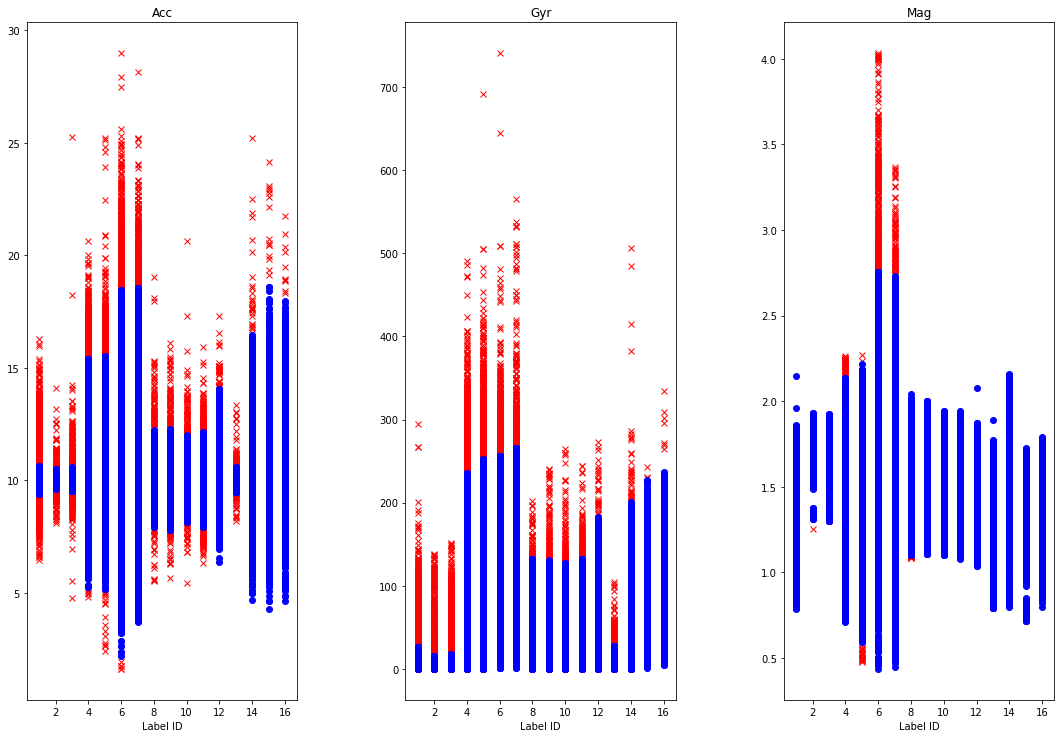

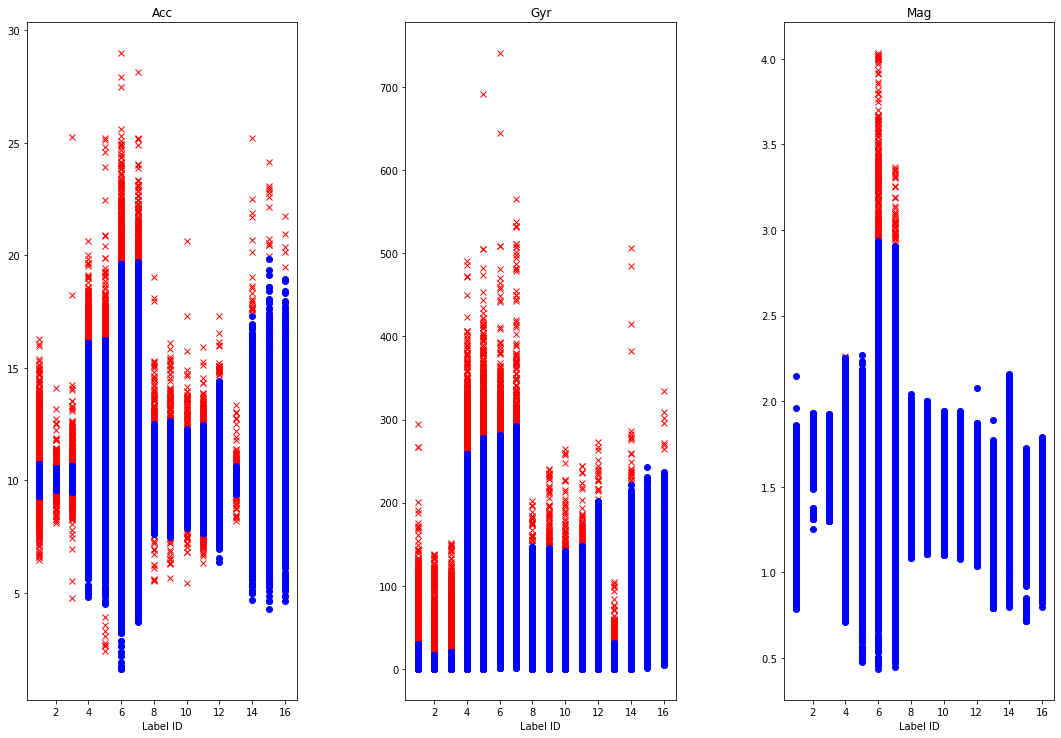

In [13]:
def z_score(activity, k):
    m = activity.mean()
    s = activity.std()
    z = (activity - m) / s

    out = activity.loc[(z < -k) | (z > k)]
    not_out = activity.loc[(z >= -k) & (z <= k)]

    return [out, not_out]

def plotZscore(data, k):
    fig, axes = plt.subplots(1,3, figsize=(15,10))
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    data.set_index('Label ID', inplace=True)
    aux=1
    for sensor in sensors:
        plt.subplot(1,3,aux)
        plt.title(sensor)
        group = data.groupby('Label ID')[sensor]
        for key, gp in group:
            [out, not_out] = z_score(gp, k)
            out.plot(legend=False, marker = 'x', color = 'red', linestyle = 'None')
            not_out.plot(legend=False, marker = 'o', color = 'blue', linestyle = 'None')
        aux +=1
    
        
def zscore(mod_data, den, sensor):
    n_outliers = []
    for id in range(1,17):
        aux = []
        activity = mod_data.loc[mod_data["Label ID"] == id, sensor]
        for k in k_value:
            [out, not_out] = z_score(activity, k)

            aux.append(out.shape[0])
            
        aux = pd.DataFrame(aux)
        aux.columns = [id]
        aux.index = k_value

        n_outliers.append(aux)

    n_outliers = pd.concat(n_outliers, axis=1)
    n_outliers = n_outliers.transpose()

    data_zscore = pd.concat([den[['Label', 'Label Name', sensor + ' N_Total', sensor + ' N_Outliers']], n_outliers], axis=1)

    display(data_zscore)



mod_data = modulo(dataFrame)
zscore(mod_data, den, 'Acc')
zscore(mod_data, den, 'Gyr')
zscore(mod_data, den, 'Mag')


mod_data = modulo(dataFrame)
plotZscore(mod_data, 3)
mod_data = modulo(dataFrame)
plotZscore(mod_data, 3.5)
mod_data = modulo(dataFrame)
plotZscore(mod_data, 4)



### 3.6. K-means

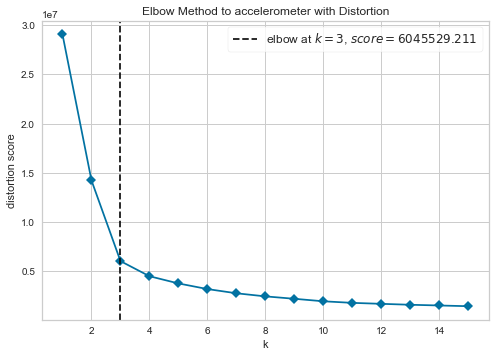

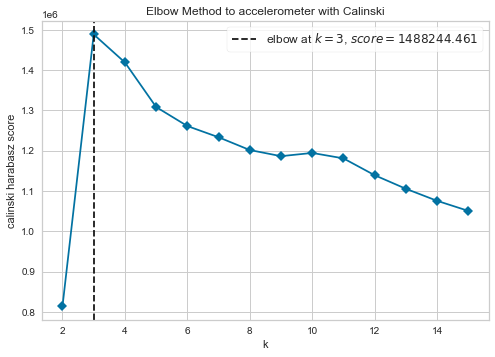

In [53]:
#https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

def elbow_method(data, maxK, sensor):

    
    graph = KElbowVisualizer(KMeans(), k=(1,maxK), metric='distortion', timings=False, locate_elbow=True, title='Elbow Method to ' + sensor + ' with Distortion')
    graph.fit(data[[sensor + ' x', sensor + ' y', sensor + ' z']].to_numpy())       
    graph.show()

    graph = KElbowVisualizer(KMeans(), k=(2,maxK), metric='calinski_harabasz', timings=False, locate_elbow=True, title='Elbow Method to ' + sensor + ' with Calinski')
    graph.fit(data[[sensor + ' x', sensor + ' y', sensor + ' z']].to_numpy())       
    graph.show()

maxK = 16
elbow_method(dataFrame, maxK, 'accelerometer')

In [54]:
def updateCentroids(data, clusters, centroids, n_cluster, sensor):
    for i in range(n_cluster):
        centroids[0][i] = (data.iloc[clusters[i].index][sensor + ' x']).mean()
        centroids[1][i] = (data.iloc[clusters[i].index][sensor + ' y']).mean()
        centroids[2][i] = (data.iloc[clusters[i].index][sensor + ' z']).mean()

    return centroids

def make_clusters(newData, clusters, n_cluster):

    lista = [i for i in range(n_cluster)]

    newData['Cluster'] = newData[lista].idxmin(axis=1)

    for i in range(n_cluster):
        clusters[i] = (newData[newData['Cluster'] == i])
        clusters[i] = clusters[i][i]
    
    return clusters, newData


def distances(sensorData, sensor, newData, centroids, n_cluster):
    for i in range(n_cluster):
        newData[i] = np.sqrt((pd.DataFrame(sensorData[sensor + ' x'].tolist()).subtract(centroids[0][i], axis=1) + pd.DataFrame(sensorData[sensor + ' y'].tolist()).subtract(centroids[1][i], axis=1) + pd.DataFrame(sensorData[sensor + ' z'].tolist()).subtract(centroids[2][i], axis=1)) ** 2)

    return newData


def init_centroids(data, sensor, n_cluster):
    centroids = np.zeros((n_cluster, 3),  dtype=object)

    pos = np.random.choice(data.shape[0], n_cluster, replace=False)

    for i in range(n_cluster):
        centroids[i][0] = data.iloc[pos[i]][sensor + ' x']
        centroids[i][1] = data.iloc[pos[i]][sensor + ' y']
        centroids[i][2] = data.iloc[pos[i]][sensor + ' z']

    centroids = pd.DataFrame(centroids)

    return centroids

  
def k_means(data, sensor, n_cluster, maxIt):  

    sensorData = data[[sensor + ' x', sensor + ' y', sensor + ' z']]

    centroids = init_centroids(sensorData, sensor, n_cluster)

    newData = np.zeros((sensorData.shape[0], n_cluster + 1),  dtype=object)
    newData = pd.DataFrame(newData)
    newData.columns = [*newData.columns[:-1], 'Cluster']

    clusters = [[] for i in range(n_cluster)]

    for i in range(maxIt):
        #print("---------------------" + str(i) + "-----------------------")
        newData = distances(sensorData, sensor, newData, centroids, n_cluster)
        clusters, newData = make_clusters(newData, clusters, n_cluster)
        oldCentr = centroids.copy()
        centroids = updateCentroids(data, clusters, centroids, n_cluster, sensor)
        
        if centroids.equals(oldCentr):
            break

    return clusters, centroids

maxIt = 100
n_clusters = 3
clusters, centroids = k_means(dataFrame, 'accelerometer', n_clusters, maxIt)


### 3.7. Plot clusters with K-means

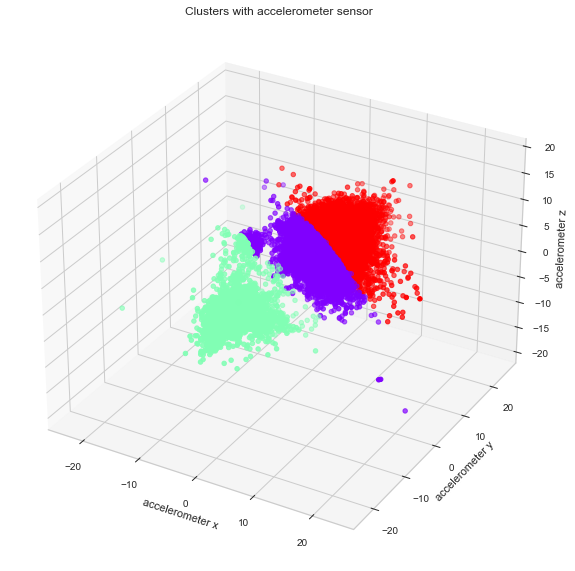

In [56]:
#https://stackoverflow.com/questions/12236566/setting-different-color-for-each-series-in-scatter-plot-on-matplotlib

import matplotlib.cm as cm

def plot_clusters(data, centroids, clusters, n_cluster, sensor):
    fig = plt.figure(figsize=(15,10))
    ax = plt.axes(projection='3d')
    ax.set_title("Clusters with " + sensor + ' sensor')
    ax.set_xlabel(sensor + ' x')
    ax.set_ylabel(sensor + ' y')
    ax.set_zlabel(sensor + ' z')

    x = np.arange(centroids.shape[0])
    ys = [i+x+(i*x)**2 for i in range(centroids.shape[0])]

    colors = cm.rainbow(np.linspace(0, 1, len(ys)))

    for i in range(n_cluster):
        ax.scatter3D(centroids[0][i],centroids[1][i],centroids[2][i], color = 'black', marker='x', linewidth=4)

    for i in range(n_cluster):
        points = data.iloc[clusters[i].index]
        ax.scatter3D(points[sensor + ' x'], points[sensor + ' y'], points[sensor + ' z'], color = colors[i], marker='o', linewidth = 1)

    

plot_clusters(dataFrame, centroids, clusters, n_clusters, 'accelerometer')

### 3.8. Outlier Injection 

d = (n0 / nr) * 100

Se dens < x -> sorteia (x-dens)% de not_out random -> cada ponto p <- m + s * k * (std+q)

In [14]:
def outlier_injection(data, x, k):
    data = data.copy()
    m = data.mean()
    std = data.std()
    
    out, not_out = z_score(data, k)

    d_out = (out.shape[0]/data.shape[0]) * 100

    print('Initial density: {:.3f}\tOutliers count: {:d}'.format(d_out, out.shape[0]))

    z = abs(max(out, default=0) - (m + k*std)) 

    if(d_out < x):
        nr_points = int(np.ceil(data.shape[0] * (x-d_out)/100))
        inj_point = not_out.sample(nr_points)

        for index, value in inj_point.items():
            q = np.random.uniform(0, z)
            s = random.choice([-1,1])
            data[index] = m + s * k * (std + q)

        out, not_out = z_score(data, k)
        d_out = (out.shape[0]/data.shape[0]) * 100
        print('Final density: {:.3f}\tOutliers count: {:d}'.format(d_out, out.shape[0]))

    return [data, out, not_out]


### 3.9. Modelo Linear

$\beta = (X^TX)^{-1} X^TY$

pinv -> pseudo-transposta = $(X^TX)^{-1} X$

In [15]:
def linear_model(window, p):
    Y = np.matrix([[window[i]] for i in range(p, len(window))])

    A = np.matrix([np.insert(window[p+i:i:-1],0,1) for i in reversed(range(len(window)-p))]) #insere uns na primeira coluna da matriz

    beta = np.squeeze(np.asarray(np.linalg.pinv(A).dot(Y)))

    return beta

### Exercicio 3.10.

### Leave One Out

In [16]:
def leave_one_out(window, p_test):
    errors = []
    
    for p in p_test:
        error = 0
        for i in range(p, len(window)):

            aux = window.copy()
            aux.remove(aux[i])
            
            betas = linear_model(aux, p)
            
            predicted_value = 0
            predicted_value += betas[0]
            
            for j in range(1, len(betas)):
                predicted_value += betas[j]*window[i-j]
                
            error += np.power(window[i] - predicted_value, 2)
        errors.append(error)
    
    return(p_test[errors.index(min(errors))])

Initial density: 0.237	Outliers count: 199
Final density: 4.540	Outliers count: 3812


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


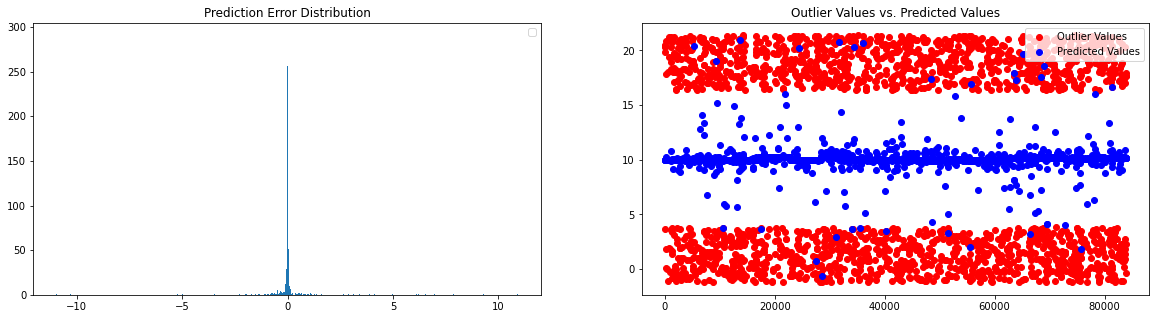

In [17]:
def ex3_10():
    mod_data = modulo(dataFrame)
    activity = mod_data.loc[mod_data['Label ID'] == 2]['Acc']
    inj_data, out, not_out = outlier_injection(activity,10,3)

    window_size = 15
    num_p = 10

    frame = {'Real Values': activity, 'Injected Values': inj_data, 'Predicted Values': None, 'Predicted': [False for _ in range(len(inj_data))],
            'Category': ['Not Outlier' for _ in range(len(inj_data))]}
    
    data = pd.DataFrame(frame)
    data.loc[data.index.isin(out.index), 'Category'] = 'Outlier'
    data = data.reset_index(drop=True)

    outlier = data.loc[data['Category'] == 'Outlier'].index.tolist()
    
    for index in outlier:
        if index > window_size:
            window = data.loc[index-window_size-1:index-1]
            
            if len(window.loc[window['Category'] == 'Outlier']) > 0:
                p = leave_one_out(window['Injected Values'].tolist(), np.arange(1,num_p+1))
                betas = linear_model(window['Injected Values'].tolist(), p)
                
                prediction = betas[0]
                for i in range(1, len(betas)):
                    prediction += float(betas[i] * data.loc[index-i, ['Injected Values']])

                data.loc[index, ['Predicted Values']] = prediction
                data.loc[index, ['Predicted']] = True

    return data

def plot(data):
    fig, (plt_err_dist, plt_rp) = plt.subplots(1,2, figsize=(20,5))

    plt_err_dist.set_title('Prediction Error Distribution')
    plt_err_dist.hist(data.loc[data['Predicted']]['Real Values'] - data.loc[data['Predicted']]['Predicted Values'], bins = len(data.loc[data['Predicted']]))
    plt_err_dist.legend()

    plt_rp.set_title('Outlier Values vs. Predicted Values')
    plt_rp.scatter(list(data.loc[data['Predicted']].index), data.loc[data['Predicted']]['Injected Values'], color = 'red', label = 'Outlier Values')
    plt_rp.scatter(list(data.loc[data['Predicted']].index), data.loc[data['Predicted']]['Predicted Values'], color = 'blue', label = 'Predicted Values')
    plt_rp.legend()


for_plot = ex3_10()
plot(for_plot)

### Exercício 4.1. 

In [35]:
mod_data = modulo(dataFrame)

def plot(data):
    
    loc, scale = stats.norm.fit(data)
    #create a normal distribution with loc and scale
    normal = stats.norm(loc=loc, scale=scale)

    bins = np.arange(np.array(data).min(), np.array(data).max(), 0.05) #O limiar comum é 0.05
    plt.hist(data, bins = bins, density = True)

    x = np.arange(np.array(data).min(), np.array(data).max()+0.2, 0.2)
    plt.plot(x, normal.pdf(x))
    plt.show()

def normal_test(data):
    for id in range(1,17):
        print("-"*60)
        print('Activity: {:s} ({:d})'.format(activities[id-1], id))
        for s in sensors:
            activity = data.loc[data['Label ID'] == id, s]

            ks_stats, p_value = stats.kstest(activity, 'norm')

            print(s + ' Module\nKS statistic: ', ks_stats,'\tP value: ', p_value)

            #plot(activity)

normal_test(mod_data)

------------------------------------------------------------
Activity: Stand (1)
Acc Module
KS statistic:  0.9999999999434107 	P value:  0.0
Gyr Module
KS statistic:  0.6152749946720814 	P value:  0.0
Mag Module
KS statistic:  0.787095259688979 	P value:  0.0
------------------------------------------------------------
Activity: Sit (2)
Acc Module
KS statistic:  0.9999999999999997 	P value:  0.0
Gyr Module
KS statistic:  0.5407134383978316 	P value:  0.0
Mag Module
KS statistic:  0.9066271737285365 	P value:  0.0
------------------------------------------------------------
Activity: Sit and Talk (3)
Acc Module
KS statistic:  0.999999092516171 	P value:  0.0
Gyr Module
KS statistic:  0.5619170820609398 	P value:  0.0
Mag Module
KS statistic:  0.9048835615105808 	P value:  0.0
------------------------------------------------------------
Activity: Walk (4)
Acc Module
KS statistic:  0.9999992914922885 	P value:  0.0
Gyr Module
KS statistic:  0.9760904419075495 	P value:  0.0
Mag Module
KS 

### Exercício 4.2.

In [45]:
def mean(data):
    return data.mean(numeric_only=True)

def median(data):
    return data.median(numeric_only=True)

def std(data):
    return data.std(numeric_only=True)

def variance(data):
    return data.var(numeric_only=True)

def rms(data):
    aux = data.copy()
    aux.pop('Label Name')
    return np.sqrt(mean(aux.pow(2)))

def ad(data):
    aux = data.copy()
    aux.pop('Label Name')
    return mean(aux.diff())

def skew(data):
    return data.skew(numeric_only=True)

def kurtosis(data):
    return data.kurtosis(numeric_only=True)

def iqr(data):
    return data.quantile(0.75) - data.quantile(0.25)

def zcr(data):
    aux = data.copy()
    aux.pop('Label Name')
    return ((aux[:-1] * aux[1:]) < 0).sum()

def mcr(data):
    aux = data.copy()
    aux.pop('Label Name')
    return (((aux[:-1] - aux.mean()) * (aux[1:] - aux.mean())) < 0).sum()

def correlation(data, sensor):
    return data[[sensor + ' x', sensor + ' y',  sensor + ' z']].corr()

def spectral_entropy(x, sf, method='welch', nperseg=None, normalize=False):
    #https://raphaelvallat.com/entropy/build/html/generated/entropy.spectral_entropy.html
    x = np.array(x)
    if method == 'fft':
        _, pxx = periodogram(x, sf)
    elif method == 'welch':
        _, pxx = welch(x, sf, nperseg=len(x) - 1)
    pxx_norm = np.divide(pxx, pxx.sum())    #TODO ver de onde vem
    se = -np.multiply(pxx_norm, np.log2(pxx_norm)).sum()
    if normalize:
        se /= np.log2(pxx_norm.size)
    return se

def movement_intensity(data, sensor):
    return np.sqrt(((data[sensor + ' x'])**2) + ((data[sensor + ' y'])**2) + ((data[sensor + ' z'])**2))

def ai_mi(data, sensor):
    sum = np.sum(movement_intensity(data, sensor))
    return (1/len(data)) * sum

def vi_mi(data, sensor):
    sum = np.sum((movement_intensity(data, sensor) - ai_mi(data, sensor)) ** 2)
    return (1/len(data)) * sum

def sma(data, sensor):
    x = np.sum(np.abs(data[sensor + ' x']))
    y = np.sum(np.abs(data[sensor + ' y']))
    z = np.sum(np.abs(data[sensor + ' z']))
    return (1/len(data)) * (x + y + z)

def eva(data, sensor):
    mat = np.array([data[sensor + ' x'], data[sensor + ' y'], data[sensor + ' z']])
    cov = np.cov(mat, bias=True)
    eig_values, _ = np.linalg.eig(cov)
    eig_values = sorted(eig_values)
    return [eig_values[-1], eig_values[-2]]

def cagh(data, sensor):
    yz = np.sqrt((data[sensor + ' y'] ** 2) + (data[sensor + ' z'] ** 2))   #https://hadrienj.github.io/posts/Deep-Learning-Book-Series-2.5-Norms/
    x = data[sensor + ' x']
    return np.corrcoef(yz, x)[1][0]

def df(data, sensor, sf):
    freqs, pxx = periodogram(data, sf)

    fft_squared = pxx ** 2

    index_max = list(fft_squared).index(max(list(fft_squared)))

    return freqs[index_max]

def energy(data, sensor, sf):
    _, pxx = periodogram(data, sf)

    fft_squared = pxx ** 2

    return np.sum(fft_squared) / len(data)

def aae_are(x, y, z):
    return (x + y + z) / 3


### TO DO
-> Correlação entre sensores <br>
-> 5, 6 e 7 do paper

In [48]:
f = 51.2
T=1/f
windowT = 2

f_window = round(windowT/T)

activities_by_window = {
    'Stand':[],
    'Sit':[],
    'Sit and Talk':[],
    'Walk':[],
    'Walk and Talk':[],
    'Climb Stair (up/down)':[],
    'Climb Stair (up/down) and talk':[],
    'Stand -> Sit':[],
    'Sit -> Stand':[],
    'Stand -> Sit and talk':[],
    'Sit -> Stand and talk':[],
    'Stand -> walk':[],
    'Walk -> stand':[],
    'Stand -> climb stairs (up/down)(and talk)':[],
    'Climb stairs (up/down) -> walk':[],
    'Climb stairs (up/down) and talk -> walk and talk':[],
}


for interval in range(0,len(dataFrame)-f_window,f_window):
    if dataFrame.iloc[interval]["Label Name"] == dataFrame.iloc[interval+f_window]["Label Name"]:
        activities_by_window[dataFrame.iloc[interval]["Label Name"]].append(dataFrame.iloc[interval:interval+f_window])

def columns(sensor):
    xyz = ['X', 'Y', 'Z']
    feature = ['Mean', 'Median', 'Std', 'Variance', 'RMS', 'AD', 'Skew', 'Kurtosis', 'IQR', 'ZCR', 'MCR', 'Spec Ent', 'DF', 'Energy']
    feature2 = ['X Y Corr', 'X Z Corr', 'Y Z Corr']
    
    if sensor == 'Acc':
         feature2 += ['AI', 'VI', 'SMA', 'EVA Vertical', 'EVA Horizontal', 'AVH', 'AVG', 'AAE', 'CAGH']

    elif sensor == 'Gyr':
        feature2 += ['ARE']

    feature_col = ['Label'] + [sensor + ' ' + col + ' ' + f for col in xyz for f in feature] + [sensor + ' ' + f for f in feature2]

    return pd.DataFrame(columns = feature_col)

def extraction_feature(data, sensor, columns):
    if sensor == 'Acc':
        s = 'accelerometer' 
    elif sensor == 'Gyr':
        s = 'gyroscope' 
    else:
        s = 'magnetometer'

    for k,v in data.items():
        for valor in v:
            media = mean(valor)
            mediana = median(valor)
            desv = std(valor)
            var = variance(valor)
            root = rms(valor)
            ave = ad(valor)
            sk = skew(valor)
            kurt = kurtosis(valor)
            quartil = iqr(valor)
            zero = zcr(valor)
            meancr = mcr(valor)  
            corr = correlation(valor, s)    
            specx = spectral_entropy(valor[s + ' x'], f)
            specy = spectral_entropy(valor[s + ' y'], f)
            specz = spectral_entropy(valor[s + ' z'], f)  
            dfx = df(valor[s + ' x'], s, f)
            dfy = df(valor[s + ' y'], s, f)
            dfz = df(valor[s + ' z'], s, f)
            energyx = energy(valor[s + ' x'], s, f)
            energyy = energy(valor[s + ' y'], s, f)
            energyz = energy(valor[s + ' z'], s, f)

            if(sensor == 'Acc'):
                ai_miv = ai_mi(valor, s)    
                vi_miv = vi_mi(valor, s)  
                smav = sma(valor, s)
                [eva_v, eva_h] = eva(valor, s)
                caghv = cagh(valor, s)
                aaev = aae_are(energyx, energyy, energyz)

                new_columns = pd.DataFrame({
                    'Label': k,
                    sensor + ' X Mean': [media[s + ' x']], sensor + ' Y Mean': [media[s + ' y']], sensor + ' Z Mean': [media[s + ' z']],
                    sensor + ' X Median': [mediana[s + ' x']], sensor + ' Y Median': [mediana[s + ' y']], sensor + ' Z Median': [mediana[s + ' z']],
                    sensor + ' X Std': [desv[s + ' x']], sensor + ' Y Std': [desv[s + ' y']], sensor + ' Z Std': [desv[s + ' z']],
                    sensor + ' X Variance': [var[s + ' x']], sensor + ' Y Variance': [var[s + ' y']], sensor + ' Z Variance': [var[s + ' z']],
                    sensor + ' X RMS': [root[s + ' x']], sensor + ' Y RMS': [root[s + ' y']], sensor + ' Z RMS': [root[s + ' z']],
                    sensor + ' X AD': [ave[s + ' x']], sensor + ' Y AD': [ave[s + ' y']], sensor + ' Z AD': [ave[s + ' z']],
                    sensor + ' X Skew': [sk[s + ' x']], sensor + ' Y Skew': [sk[s + ' y']], sensor + ' Z Skew': [sk[s + ' z']],
                    sensor + ' X Kurtosis': [kurt[s + ' x']], sensor + ' Y Kurtosis': [kurt[s + ' y']], sensor + ' Z Kurtosis': [kurt[s + ' z']],
                    sensor + ' X IQR': [quartil[s + ' x']], sensor + ' Y IQR': [quartil[s + ' y']], sensor + ' Z IQR': [quartil[s + ' z']],
                    sensor + ' X ZCR': [zero[s + ' x']], sensor + ' Y ZCR': [zero[s + ' y']], sensor + ' Z ZCR': [zero[s + ' z']],
                    sensor + ' X MCR': [meancr[s + ' x']], sensor + ' Y MCR': [meancr[s + ' y']], sensor + ' Z MCR': [meancr[s + ' z']],
                    sensor + ' X Y Corr': [corr.loc[s + ' x', s + ' y']], sensor + ' X Z Corr': [corr.loc[s + ' x', s + ' z']], sensor + ' Y Z Corr': [corr.loc[s + ' y', s + ' z']],
                    sensor + ' X Spec Ent': [specx], sensor + ' Y Spec Ent': [specy], sensor + ' Z Spec Ent': [specz],
                    sensor + ' AI': [ai_miv], sensor + ' VI': [vi_miv],
                    sensor + ' SMA': [smav],
                    sensor + ' EVA Vertical': [eva_v], sensor + ' EVA Horizontal': [eva_h],
                    sensor + ' CAGH': [caghv],
                    sensor + ' X DF': [dfx], sensor + ' Y DF': [dfy], sensor + ' Z DF': [dfz],
                    sensor + ' X Energy': [energyx], sensor + ' Y Energy': [energyy], sensor + ' Z Energy': [energyz],
                    sensor + ' AAE': [aaev]
            })

            elif(sensor == 'Gyr'):
                arev = aae_are(energyx, energyy, energyz)

                new_columns = pd.DataFrame({
                    'Label': k,
                    sensor + ' X Mean': [media[s + ' x']], sensor + ' Y Mean': [media[s + ' y']], sensor + ' Z Mean': [media[s + ' z']],
                    sensor + ' X Median': [mediana[s + ' x']], sensor + ' Y Median': [mediana[s + ' y']], sensor + ' Z Median': [mediana[s + ' z']],
                    sensor + ' X Std': [desv[s + ' x']], sensor + ' Y Std': [desv[s + ' y']], sensor + ' Z Std': [desv[s + ' z']],
                    sensor + ' X Variance': [var[s + ' x']], sensor + ' Y Variance': [var[s + ' y']], sensor + ' Z Variance': [var[s + ' z']],
                    sensor + ' X RMS': [root[s + ' x']], sensor + ' Y RMS': [root[s + ' y']], sensor + ' Z RMS': [root[s + ' z']],
                    sensor + ' X AD': [ave[s + ' x']], sensor + ' Y AD': [ave[s + ' y']], sensor + ' Z AD': [ave[s + ' z']],
                    sensor + ' X Skew': [sk[s + ' x']], sensor + ' Y Skew': [sk[s + ' y']], sensor + ' Z Skew': [sk[s + ' z']],
                    sensor + ' X Kurtosis': [kurt[s + ' x']], sensor + ' Y Kurtosis': [kurt[s + ' y']], sensor + ' Z Kurtosis': [kurt[s + ' z']],
                    sensor + ' X IQR': [quartil[s + ' x']], sensor + ' Y IQR': [quartil[s + ' y']], sensor + ' Z IQR': [quartil[s + ' z']],
                    sensor + ' X ZCR': [zero[s + ' x']], sensor + ' Y ZCR': [zero[s + ' y']], sensor + ' Z ZCR': [zero[s + ' z']],
                    sensor + ' X MCR': [meancr[s + ' x']], sensor + ' Y MCR': [meancr[s + ' y']], sensor + ' Z MCR': [meancr[s + ' z']],
                    sensor + ' X Y Corr': [corr.loc[s + ' x', s + ' y']], sensor + ' X Z Corr': [corr.loc[s + ' x', s + ' z']], sensor + ' Y Z Corr': [corr.loc[s + ' y', s + ' z']],
                    sensor + ' X Spec Ent': [specx], sensor + ' Y Spec Ent': [specy], sensor + ' Z Spec Ent': [specz],
                    sensor + ' X DF': [dfx], sensor + ' Y DF': [dfy], sensor + ' Z DF': [dfz],
                    sensor + ' X Energy': [energyx], sensor + ' Y Energy': [energyy], sensor + ' Z Energy': [energyz],
                    sensor + ' ARE': [arev]
                })

            else:
                new_columns = pd.DataFrame({
                    'Label': k,
                    sensor + ' X Mean': [media[s + ' x']], sensor + ' Y Mean': [media[s + ' y']], sensor + ' Z Mean': [media[s + ' z']],
                    sensor + ' X Median': [mediana[s + ' x']], sensor + ' Y Median': [mediana[s + ' y']], sensor + ' Z Median': [mediana[s + ' z']],
                    sensor + ' X Std': [desv[s + ' x']], sensor + ' Y Std': [desv[s + ' y']], sensor + ' Z Std': [desv[s + ' z']],
                    sensor + ' X Variance': [var[s + ' x']], sensor + ' Y Variance': [var[s + ' y']], sensor + ' Z Variance': [var[s + ' z']],
                    sensor + ' X RMS': [root[s + ' x']], sensor + ' Y RMS': [root[s + ' y']], sensor + ' Z RMS': [root[s + ' z']],
                    sensor + ' X AD': [ave[s + ' x']], sensor + ' Y AD': [ave[s + ' y']], sensor + ' Z AD': [ave[s + ' z']],
                    sensor + ' X Skew': [sk[s + ' x']], sensor + ' Y Skew': [sk[s + ' y']], sensor + ' Z Skew': [sk[s + ' z']],
                    sensor + ' X Kurtosis': [kurt[s + ' x']], sensor + ' Y Kurtosis': [kurt[s + ' y']], sensor + ' Z Kurtosis': [kurt[s + ' z']],
                    sensor + ' X IQR': [quartil[s + ' x']], sensor + ' Y IQR': [quartil[s + ' y']], sensor + ' Z IQR': [quartil[s + ' z']],
                    sensor + ' X ZCR': [zero[s + ' x']], sensor + ' Y ZCR': [zero[s + ' y']], sensor + ' Z ZCR': [zero[s + ' z']],
                    sensor + ' X MCR': [meancr[s + ' x']], sensor + ' Y MCR': [meancr[s + ' y']], sensor + ' Z MCR': [meancr[s + ' z']],
                    sensor + ' X Y Corr': [corr.loc[s + ' x', s + ' y']], sensor + ' X Z Corr': [corr.loc[s + ' x', s + ' z']], sensor + ' Y Z Corr': [corr.loc[s + ' y', s + ' z']],
                    sensor + ' X Spec Ent': [specx], sensor + ' Y Spec Ent': [specy], sensor + ' Z Spec Ent': [specz],
                    sensor + ' X DF': [dfx], sensor + ' Y DF': [dfy], sensor + ' Z DF': [dfz],
                    sensor + ' X Energy': [energyx], sensor + ' Y Energy': [energyy], sensor + ' Z Energy': [energyz]
            })

            columns = pd.concat([columns, new_columns], ignore_index=True)
  

    return columns


result = columns("Acc")
result_acc = extraction_feature(activities_by_window, "Acc", result)
result_acc.to_csv('Acc_features.csv', encoding='utf-8')

result = columns("Gyr")
result_gyr = extraction_feature(activities_by_window, "Gyr", result)
result_gyr.to_csv('Gyr_features.csv', encoding='utf-8')

result = columns("Mag")
result_mag = extraction_feature(activities_by_window, "Mag", result)
result_mag.to_csv('Mag_features.csv', encoding='utf-8')



### 4.3. PCA

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [74]:
def normalize(data):
    #https://en.wikipedia.org/wiki/Normalization_(statistics)
    for col in data.columns:
        if (col != "Label"):
            m = data[col].mean()
            std = data[col].std()
            if (std != 0): data[col] = (data[col]- m ) / std # Verificar
    return data

data_norm_acc = normalize(result_acc).dropna(axis=1, how='all')
data_norm_gyr = normalize(result_gyr).dropna(axis=1, how='all')
data_norm_mag = normalize(result_mag).dropna(axis=1, how='all')


In [75]:
from sklearn.preprocessing import StandardScaler

def standard(data):
    features = data.drop("Label", axis = 1)
    target = data["Label"]

    return [StandardScaler().fit_transform(features), target]

[features_acc, target_acc] = standard(data_norm_acc)
[features_gyr, target_gyr] = standard(data_norm_gyr)
[features_mag, target_mag] = standard(data_norm_mag)

In [77]:
from sklearn.decomposition import PCA

def pca(data,target, n_components): 

    ppca = PCA(n_components)
    principalComponents = ppca.fit_transform(data)

    principalDf = pd.DataFrame(data = principalComponents, columns = ['Principal Component ' + str(i+1) for i in range(principalComponents.shape[1])])
    finalDf = pd.concat([principalDf, target], axis = 1)

    return finalDf

pca_acc = pca(features_acc,target_acc, 0.75)
pca_gyr = pca(features_gyr, target_gyr, 0.75)
pca_mag = pca(features_mag, target_mag, 0.75)

display(pca_acc)
display(pca_gyr)
display(pca_mag)

,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,Principal Component 6,Principal Component 7,Principal Component 8,Principal Component 9,Principal Component 10,Principal Component 11,Principal Component 12,Label
0,-2.600899,-1.056859,-0.799687,0.377951,1.054193,2.489371,-0.236979,-0.199130,-0.245801,-3.196331,0.177807,0.507885,Stand
1,-1.806595,-1.375511,-1.483278,-1.294501,2.482852,1.060062,0.218851,-0.899036,-1.795289,-2.004304,0.086589,0.168152,Stand
2,-2.744980,-1.643721,-0.034557,1.638494,-0.685529,3.527736,0.609663,0.197753,-0.094690,0.804867,1.248639,0.024980,Stand
3,-3.306927,-1.108668,0.364323,2.110533,-0.675283,1.977150,1.036297,1.193242,0.709354,0.656800,-1.201058,0.037271,Stand
4,-3.530685,-0.045355,0.324938,1.417010,-0.337607,0.526344,0.518667,0.988293,0.905037,-1.374471,-2.420952,0.168066,Stand
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7239,3.510822,0.649072,-0.134117,2.412737,-0.986919,-0.084069,-0.475052,0.616653,0.846619,-0.323017,0.405427,-1.850748,Climb stairs (up/down) -> walk
7240,3.352282,0.708499,0.425135,1.628281,-0.953502,0.020829,-1.207056,-0.917851,0.162915,0.004817,-0.930777,0.370491,Climb stairs (up/down) -> walk
7241,5.666408,1.737890,0.087108,2.051290,-2.609399,-0.574446,-0.285411,0.088867,0.060506,-0.613581,-0.718319,-5.191649,Climb stairs (up/down) -> walk
7242,2.987577,-0.979794,-0.671771,0.753416,-0.685947,-0.256408,0.148116,-0.147839,-0.210945,2.000442,0.947005,-1.897615,Climb stairs (up/down) -> walk


,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,Principal Component 6,Principal Component 7,Principal Component 8,Principal Component 9,Principal Component 10,Label
0,-2.210432,0.185046,-1.786666,0.102673,2.325231,-1.200238,-0.594212,1.326958,-0.996484,1.812419,Stand
1,-2.554007,-0.296174,-1.016089,-0.786517,0.524817,0.702008,1.388223,1.372885,1.776391,-1.834178,Stand
2,-4.062062,0.240198,1.070337,-0.377274,0.471509,0.562258,0.795756,0.526826,1.345183,-1.595240,Stand
3,-3.928725,0.397835,0.696408,-0.341362,-0.511832,-0.426127,1.026353,0.247359,0.496771,-0.393785,Stand
4,-3.617516,0.374867,-0.202817,0.351878,-0.567651,-0.295550,-0.067815,0.501672,-0.157805,0.481757,Stand
...,...,...,...,...,...,...,...,...,...,...,...
7239,0.865216,-0.712391,-0.000112,-0.080641,-0.292739,2.000818,1.341221,-1.111906,0.046376,0.340390,Climb stairs (up/down) -> walk
7240,0.342513,0.747484,0.169233,-0.092120,0.267567,-0.742163,-0.723566,-0.588138,-0.902000,-1.888704,Climb stairs (up/down) -> walk
7241,3.536326,-1.158629,-0.157732,-1.306030,0.497790,-0.085422,-2.992027,0.413934,2.798681,-1.548385,Climb stairs (up/down) -> walk
7242,0.622626,-2.834623,0.093870,-1.519065,-0.947121,0.227163,1.860958,-1.191152,2.204377,1.570980,Climb stairs (up/down) -> walk


,Principal Component 1,Principal Component 2,Principal Component 3,Principal Component 4,Principal Component 5,Principal Component 6,Principal Component 7,Principal Component 8,Principal Component 9,Principal Component 10,Label
0,-1.961082,-0.219823,-0.989257,-1.032448,-0.776604,0.759841,0.505589,-0.062898,0.462828,-1.287680,Stand
1,-0.831255,0.245004,-1.156061,-1.424084,-1.315945,0.237274,-0.261818,-0.207448,2.208900,-1.077296,Stand
2,-3.134030,-0.068666,-0.386877,-0.466586,-0.492450,1.236575,0.984279,0.135406,-0.008768,-0.544041,Stand
3,-2.591819,0.203685,-0.480226,-0.491038,-1.173550,0.864197,0.648675,0.265288,0.080676,-1.262740,Stand
4,-3.068672,0.027742,-0.243823,-0.484417,-0.570879,1.074499,0.833553,0.239029,-0.064877,-0.949721,Stand
...,...,...,...,...,...,...,...,...,...,...,...
7239,1.800478,-2.518086,-1.062868,0.449891,0.467857,-0.221436,0.071465,-0.752137,-0.154614,-0.323472,Climb stairs (up/down) -> walk
7240,2.215015,-2.317012,-0.334030,0.004207,0.156690,0.032007,0.101862,-0.587865,0.512597,-0.543129,Climb stairs (up/down) -> walk
7241,1.548713,-3.115655,-0.001412,0.480811,0.519249,0.012621,0.513091,0.120271,-0.160794,-0.002917,Climb stairs (up/down) -> walk
7242,4.058827,-1.583031,0.029233,-2.272002,0.004999,1.567534,-1.949334,-1.103599,-2.518615,1.077070,Climb stairs (up/down) -> walk
